In [1]:
import torch
import numpy as np
import torch.nn as nn
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from torch.utils.data import DataLoader
from utils.patch_utils import _get_patches
from utils.get_embds import get_embeddings
from utils.queues import Embedding_Queues
from utils.datasets_PASCAL_findContours import PascalVOCDataset
from utils.model import Network

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
patch_size = 14
contrastie_weigth = "0.1"
img_size = 224
batch_size = 8
num_classes = 2
embedding_size = 128
epoch = 50

voc_mask_color_map = [
    [0, 0, 0], #_background
    [128, 0, 0] #kidney
]

dataset_path = '/home/u5169119/dataset/0_data_dataset_voc_950_kidney'
output_dir ='dataset/splits/kidney'
# model_path = f"output/{patch_size}-{contrastie_weigth}/model_supervised-Pretraining_50-s.pth"
# model_path = f"output/{patch_size}-{contrastie_weigth}/model_supervised-Pretraining_100-s.pth"
model_path = f"output/base_line_model/{patch_size}-{contrastie_weigth}/model_supervised-Pretraining_{epoch}-s.pth"

In [3]:
val_dataset = PascalVOCDataset(txt_file=output_dir + "/val.txt", image_size=img_size, root_dir=dataset_path, labeled=True, colormap=voc_mask_color_map)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
print('number of val_dataset: ', len(val_dataset))

number of val_dataset:  95


In [4]:
device = torch.device('cuda:0')

model = torch.load(model_path)
# model = nn.DataParallel(model)
model = model.to('cuda')
model = model.eval()
model.module.contrast = True

In [5]:
background_embedding_list = []
class1_embedding_list = []

# model = Network(num_classes, embedding_size=embedding_size)
# model = nn.DataParallel(model)
# model = model.to('cuda')
# model.module.contrast = True

# 提取 embeddings
with torch.no_grad():
    for imgs, masks in tqdm(val_loader):
        patch_list = _get_patches(
            imgs, masks,
            classes=num_classes,
            background=True,
            img_size=img_size,
            patch_size=patch_size
        )
        
        qualified_tensor_patch_list = [torch.tensor(patch) if patch is not None else None for patch in patch_list]
        emb_list = get_embeddings(model, qualified_tensor_patch_list, True, batch_size)
        
        background_embedding_list
        # 处理 background_embeddings
        for emb in emb_list[0]:
            background_embeddings_np = emb.cpu().numpy()
            background_embedding_list.append(background_embeddings_np)
            
        # 处理 class1_embeddings
        for emb in emb_list[1]:
            class1_embeddings_np = emb.cpu().numpy()
            class1_embedding_list.append(class1_embeddings_np)
            
        break

  0%|          | 0/12 [00:01<?, ?it/s]


In [6]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from tqdm import tqdm
from umap import umap_ as UMAP
from sklearn.preprocessing import StandardScaler

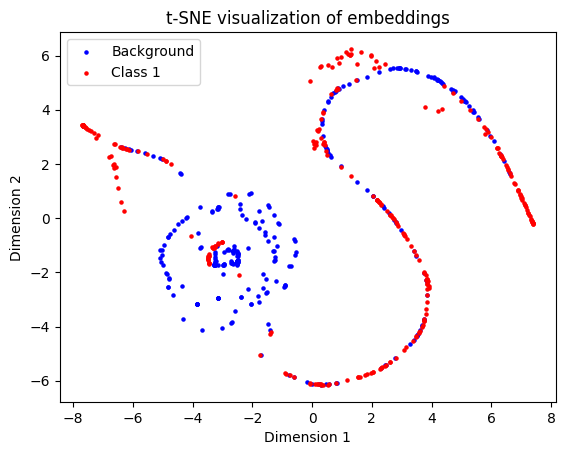

In [7]:
# 合併兩個類別的嵌入向量
embedding_tensor = np.vstack((background_embedding_list[:300], class1_embedding_list[:300]))

# 標準化數據
scaler = StandardScaler()
embedding_tensor_normalized = scaler.fit_transform(embedding_tensor)

# 使用 t-SNE 進行降維，進一步調整超參數
tsne = TSNE(n_components=2, learning_rate=1, early_exaggeration=4, n_iter=400, init='random', random_state=10)
embedding_2d = tsne.fit_transform(embedding_tensor_normalized)

# 獲取每個類別的 t-SNE 結果
background_embedding_2d = embedding_2d[:300]
class1_embedding_2d = embedding_2d[300:]

# 可視化降維後的結果
plt.scatter(background_embedding_2d[:, 0], background_embedding_2d[:, 1], s=5, color='blue', label='Background')
plt.scatter(class1_embedding_2d[:, 0], class1_embedding_2d[:, 1], s=5, color='red', label='Class 1')
plt.title('t-SNE visualization of embeddings')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend()
plt.show()

/home/u5169119/.local/lib/python3.8/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


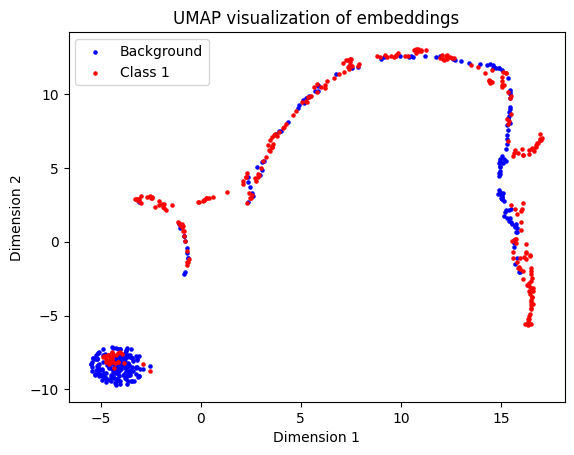

In [8]:
import umap.umap_ as umap

# 使用 UMAP 進行降維，進一步調整超參數
reducer = umap.UMAP(n_neighbors=10, min_dist=0.3, random_state=42)
embedding_2d = reducer.fit_transform(embedding_tensor_normalized)

# 獲取每個類別的 UMAP 結果
background_embedding_2d = embedding_2d[:300]
class1_embedding_2d = embedding_2d[300:]

# 可視化降維後的結果
plt.scatter(background_embedding_2d[:, 0], background_embedding_2d[:, 1], s=5, color='blue', label='Background')
plt.scatter(class1_embedding_2d[:, 0], class1_embedding_2d[:, 1], s=5, color='red', label='Class 1')
plt.title('UMAP visualization of embeddings')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend()
plt.show()


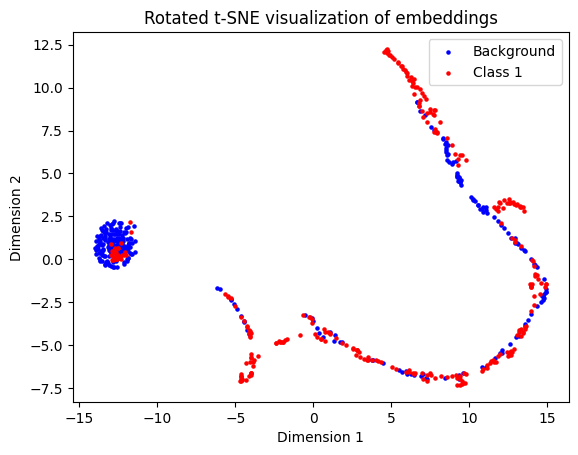

In [9]:
from sklearn.decomposition import PCA

# 使用 PCA 旋轉嵌入向量
pca = PCA(n_components=2)
embedding_rotated = pca.fit_transform(embedding_2d)
background_embedding_2d = embedding_2d[:]

# 獲取每個類別的旋轉後的 t-SNE 結果
background_embedding_rotated = embedding_rotated[:300]
class1_embedding_rotated = embedding_rotated[300:]

# 可視化旋轉後的結果
plt.scatter(background_embedding_rotated[:, 0], background_embedding_rotated[:, 1], s=5, color='blue', label='Background')
plt.scatter(class1_embedding_rotated[:, 0], class1_embedding_rotated[:, 1], s=5, color='red', label='Class 1')
plt.title('Rotated t-SNE visualization of embeddings')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend()
plt.show()


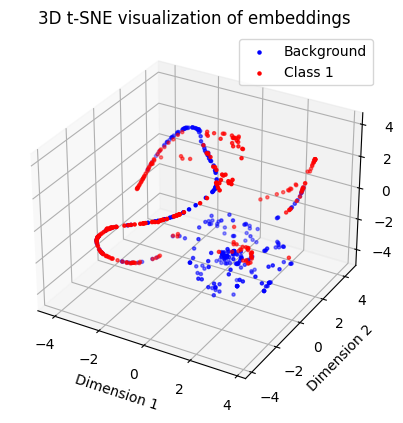

In [10]:
from mpl_toolkits.mplot3d import Axes3D

# 使用 t-SNE 進行 3D 降維
tsne_3d = TSNE(n_components=3, learning_rate=1, early_exaggeration=4, n_iter=400, init='random', random_state=10)
embedding_3d = tsne_3d.fit_transform(embedding_tensor_normalized)

# 獲取每個類別的 3D t-SNE 結果
background_embedding_3d = embedding_3d[:300]
class1_embedding_3d = embedding_3d[300:]

# 可視化 3D 降維後的結果
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(background_embedding_3d[:, 0], background_embedding_3d[:, 1], background_embedding_3d[:, 2], s=5, color='blue', label='Background')
ax.scatter(class1_embedding_3d[:, 0], class1_embedding_3d[:, 1], class1_embedding_3d[:, 2], s=5, color='red', label='Class 1')
ax.set_title('3D t-SNE visualization of embeddings')
ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')
ax.set_zlabel('Dimension 3')
plt.legend()
plt.show()